In [220]:
from pyjarowinkler import distance
from math import*
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
from sklearn.metrics import euclidean_distances
import gensim
import pymysql
import pymysql.cursors
from gensim import corpora, models
import math
from textblob import TextBlob as tb
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import requests
import json
import time
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from matplotlib.collections import LineCollection
from sklearn import manifold

In [91]:
def macro_precision(result, y, n_cluster):
    groupDict = {}
    i= 0
    for item in result:
        if item in groupDict:
            groupDict[item].append(i)
        else:
            groupDict[item] = [i]
        i = i + 1

    trueDict = {}
    i = 0
    for item in y:
        if item not in trueDict:
            trueDict[item] = [i]
        else:
            trueDict[item].append(i)
        i = i + 1

    inverseTrue = {}
    for key in trueDict.keys():
        for item in trueDict[key]:
            inverseTrue[item] = key
    
    totalNotSame = 0
    for key in groupDict.keys():
        temp = groupDict[key]
        f_id = ""
        i = 0
        control = True
        while i < len(temp) and control == True:
            f_id_cur = inverseTrue[temp[i]]
            if f_id == "":
                f_id = f_id_cur
            else:
                if f_id_cur != f_id:
                    totalNotSame += 1
                    control = False
            i += 1
                    
    return (n_cluster-totalNotSame) / n_cluster

def macro_recall(result, y, n_cluster):
    return macro_precision(y, result, n_cluster)

def micro_precision(result, y):
    lenC = len(result)
    groupDict = {}
    i= 0
    for item in result:
        if item in groupDict:
            groupDict[item].append(i)
        else:
            groupDict[item] = [i]
        i = i + 1

    trueDict = {}
    i = 0
    for item in y:
        if item not in trueDict:
            trueDict[item] = [i]
        else:
            trueDict[item].append(i)
        i = i + 1

    inverseTrue = {}
    for key in trueDict.keys():
        for item in trueDict[key]:
            inverseTrue[item] = key
    
    totalSame = 0
    for key in groupDict.keys():
        temp = groupDict[key]
        output = {}
        maxO = 0
        maxKey = ""
        for item in temp:
            f_id = inverseTrue[item]
            if f_id not in output:
                output[f_id] = 1
            else:
                output[f_id] += 1
            
            if output[f_id] > maxO:
                maxO = output[f_id]
                maxKey = key
                
        totalSame += maxO
    return  totalSame / lenC
                
def micro_recall(result, y):
    return micro_precision(y, result)


def pairwise_precision(result, y):
    lenC = len(result)
    groupDict = {}
    i= 0
    for item in y:
        if item in groupDict:
            groupDict[item].append(i)
        else:
            groupDict[item] = [i]
        i = i + 1

    trueDict = {}
    i = 0
    for item in result:
        if item not in trueDict:
            trueDict[item] = [i]
        else:
            trueDict[item].append(i)
        i = i + 1

    inverseTrue = {}
    for key in trueDict.keys():
        for item in trueDict[key]:
            inverseTrue[item] = key
    
    totalPair = 0
    totalHit = 0
    for key in groupDict.keys():
        temp = groupDict[key]
        i = 0
        j = 0
        while i < len(temp):
            while j < len(temp):
                f_id_i = inverseTrue[temp[i]]
                f_id_j = inverseTrue[temp[j]]
                if f_id_i == f_id_j:
                    totalHit += 1
                j += 1
                totalPair += 1
            i += 1
        
    return  totalHit / totalPair


def pairwise_recall(result, y):
    lenC = len(result)
    groupDict = {}
    i= 0
    for item in y:
        if item in groupDict:
            groupDict[item].append(i)
        else:
            groupDict[item] = [i]
        i = i + 1

    trueDict = {}
    i = 0
    for item in result:
        if item not in trueDict:
            trueDict[item] = [i]
        else:
            trueDict[item].append(i)
        i = i + 1

    inverseGroup = {}
    for key in groupDict.keys():
        for item in groupDict[key]:
            inverseGroup[item] = key
    
    totalPair = 0
    totalHit = 0
    for key in trueDict.keys():
        temp = trueDict[key]
        i = 0
        j = 0
        while i < len(temp):
            while j < len(temp):
                f_id_i = inverseGroup[temp[i]]
                f_id_j = inverseGroup[temp[j]]
                if f_id_i == f_id_j:
                    totalHit += 1
                j += 1
                totalPair += 1
            i += 1
        
    return  totalHit / totalPair

In [92]:
def connect_to_database():
    options = {
        'user': "root",
        'passwd': "root",
        'db': "KnowBase",
        'cursorclass' : pymysql.cursors.DictCursor
    }
    db = pymysql.connect(**options)
    db.autocommit(True)
    return db

# data clean, exclude stop word, need to to lower
def exclude_stop_word(bloblist):
    stop = set(stopwords.words('english'))
    filtered_words = [i for i in bloblist[0].lower().split() if i not in stop]
    return filtered_words


def jaccard_similarity(x, y):
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return intersection_cardinality/float(union_cardinality)

# helper for type_overlap
def lda_model(x):
    # Latent Dirichlet Allocation (LDA) for X
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(x)
    p_stemmer = PorterStemmer()
    texts = [p_stemmer.stem(i) for i in tokens]
    dictionary = corpora.Dictionary(texts)
    
    ################## errors here ##################
    
    corpus = [dictionary.doc2bow(text) for text in texts]
    print("corpus")
    print(corpus)
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=3, id2word = dictionary, passes=20)

    return ldamodel

# extract the coefficient from ldamodel
def type_overlap(m1, m2):
    pred1 = m1["A"][0]
    pred2 = m2["A"][0]
    ldamodel_x = lda_model(pred1)
    ldamodel_y = lda_model(pred2)
    print(ldamodel_x)
    print(ldamodel_y)
    jaccard_similarity(ldamodel_x, ldamodel_y)

In [179]:
def build_entity_overlap_matrix(wordList, entityOverlap):
    out = []
    for i in range(len(wordList)):
        temp = []
        for j in range(len(wordList)):
            temp.append(-1)
        out.append(temp)
        
    for i in range(len(wordList)):
        first = " ".join([wordList[i]["entity"], wordList[i]["f_id"]])
        j = i
        while j < len(wordList):
            if i != j:
                second = " ".join([wordList[j]["entity"], wordList[j]["f_id"]])
                if first in entityOverlap and second in entityOverlap[first]:
                    result = np.exp(-entityOverlap[first][second])
                else:
                    result = np.exp(-entityOverlap[second][first])
                out[i][j] = result
                out[j][i] = result
            else:
                out[i][j] = 0
            j += 1
    return out
    
def apply_entity_overlap(wordList, y, n_cluster_in, entity_matrix):
    model = AgglomerativeClustering(n_clusters=n_cluster_in, affinity="precomputed", linkage="average")
    model.fit(entity_matrix)
    result = model.labels_
    return result

In [180]:
def build_work_overlap_matrix(wordList, workOverlap):
    out = []
    for i in range(len(wordList)):
        temp = []
        for j in range(len(wordList)):
            temp.append(-1)
        out.append(temp)
        
    for i in range(len(wordList)):
        first = " ".join([wordList[i]["entity"], wordList[i]["f_id"]])
        j = i
        while j < len(wordList):
            if i != j:
                second = " ".join([wordList[j]["entity"], wordList[j]["f_id"]])
                if first in workOverlap and second in workOverlap[first]:
                    result = np.exp(-workOverlap[first][second])
                else:
                    result = np.exp(-workOverlap[second][first])
                out[i][j] = result
                out[j][i] = result
            else:
                out[i][j] = 0
            j += 1
    return out
    
def apply_work_overlap(wordList, y, n_cluster_in, work_matrix):
    model = AgglomerativeClustering(n_clusters=n_cluster_in, affinity="precomputed", linkage="average")
    model.fit(work_matrix)
    result = model.labels_
    return result

In [181]:
def idf_token_overlap(m1, m2, df_dict):
    entity1 = m1["entity"].split()
    entity2 = m2["entity"].split()
    listT = entity1
    listT.extend(entity2)
    intersection_word = set.intersection(set(entity1), set(entity2))
    union_word = set.union(set(listT))
    numerator = 0
    denominator = 0
    for word in intersection_word:
        numerator += 1 / math.log(1+df_dict[word])
    for word in union_word:
        denominator += 1 / math.log(1+df_dict[word])
    return (numerator / denominator)
    
def build_df_matrix(wordList, df_dict):
    out_df = []
    for i in range(len(wordList)):
        temp = []
        for j in range(len(wordList)):
            temp.append(-1)
        out_df.append(temp)

    i = 0
    while i < len(wordList):
        j = i
        while j < len(wordList):
            result = idf_token_overlap(wordList[i], wordList[j], df_dict)
            if i == j:
                out_df[i][i] = 0
            else:
                out_df[i][j] = np.exp(-result)
                out_df[j][i] = np.exp(-result)
            j += 1
        i += 1
    return out_df

def apply_idf_token_overlap(wordList, y, n_cluster_in, df_matrix):
    model = AgglomerativeClustering(n_clusters=n_cluster_in, affinity="precomputed", linkage="average")
    model.fit(df_matrix)
    result = model.labels_
    return result

In [187]:
db = connect_to_database()
cur = db.cursor()
string = "select b.freebase_id, b.entity, b.relation, b.value, b.link_am_score, b.link_scroe, b.base_id, "
string += "b.freebase_entity from NoiseEntity b"
cur.execute(string)
results = cur.fetchall()
groundTrue = {}
label = []
entity = []
entityDict = {}
y = []
i= 0
wordList = []
allWord = []
allEntity = []
wordDict = {}
idx = 0
for result in results:
    if result["freebase_id"] not in groundTrue:
        groundTrue[result["freebase_id"]] = i
        label.append(result["freebase_entity"].lower())
        i = i + 1
    if result["entity"] not in entityDict:
        entityDict[result["entity"].lower()] = 1
    entity.append(result["entity"].lower())
    y.append(groundTrue[result["freebase_id"]])
    
    temp = {}
    temp["n"] = result["entity"].lower().split()
    list_A = result["relation"].lower().split()
    list_A.extend(result["value"].lower().split())
    temp["A"] = list_A
    temp["f_id"] = result["freebase_id"]
    temp["f_entity"] = result["freebase_entity"]
    temp["score"] = result["link_scroe"]
    temp["am_score"] = result["link_am_score"]
    temp["relation"] = result["relation"]
    temp["value"] = result["value"]
    temp["id"] = result["base_id"]
    temp["entity"] = result["entity"]
    wordList.append(temp)
    allWord.extend(result["entity"].lower().split())
    allWord.extend(result["relation"].lower().split())
    allWord.extend(result["value"].lower().split())
    allEntity.append(result["entity"])
    entityList = result["entity"].lower().split()
    for item in entityList:
        if item not in wordDict:
            wordDict[item] = idx
            idx += 1

In [121]:
content = pd.read_csv("wordOverlap.txt", sep='\t', header=None)
workOverlap = {}
for i in range(len(content[0])):
    first = " ".join([content[0][i], content[1][i]])
    second = " ".join([content[2][i], content[3][i]])
    if first not in workOverlap:
        workOverlap[first] = { second: content[4][i] }
    else:
        workOverlap[first][second] = content[4][i]
            
    if second not in workOverlap:
        workOverlap[second] = { first: content[4][i] }
    else:
        workOverlap[second][first] = content[4][i]

In [122]:
contentEn = pd.read_csv("entityOverlap.txt", sep='\t', header=None)
entityOverlap = {}
for i in range(len(content[0])):
    first = " ".join([contentEn[0][i], contentEn[1][i]])
    second = " ".join([contentEn[2][i], contentEn[3][i]])
    if first not in entityOverlap:
        entityOverlap[first] = { second: contentEn[4][i] }
    else:
        entityOverlap[first][second] = contentEn[4][i]
            
    if second not in entityOverlap:
        entityOverlap[second] = { first: contentEn[4][i] }
    else:
        entityOverlap[second][first] = contentEn[4][i]

In [123]:
df_dict = {}
contentDf = pd.read_csv("wordCount.txt", sep='\t', header=None)
for i in range(len(contentDf[0])):
    first = contentDf[0][i]
    second = contentDf[1][i]
    df_dict[first] = second

In [171]:
work_matrix = build_work_overlap_matrix(wordList, workOverlap)

In [172]:
entity_matrix = build_entity_overlap_matrix(wordList, entityOverlap)

In [173]:
df_matrix = build_df_matrix(wordList, df_dict)

In [ ]:
## micro precision
micro_pre1 = []
micro_pre2 = []
micro_pre3 = []
## macro precision
macro_pre1 = []
macro_pre2 = []
macro_pre3 = []
## micro recall
micro_re1 = []
micro_re2 = []
micro_re3 = []
## macro recall
macro_re1 = []
macro_re2 = []
macro_re3 = []
## pairwise precision
pairwise_pre1 = []
pairwise_pre2 = []
pairwise_pre3 = []
## pairwise recall
pairwise_re1 = []
pairwise_re2 = []
pairwise_re3 = []
n_cluster = 120
while n_cluster <= 160:
    print("start")
    result1 = apply_work_overlap(wordList, y, n_cluster, work_matrix)
    result2 = apply_entity_overlap(wordList, y, n_cluster, entity_matrix)
    result3 = apply_idf_token_overlap(wordList, y, n_cluster, df_matrix)
    ## micro
    micro_pre1.append(micro_precision(result1, y))
    micro_pre2.append(micro_precision(result2, y))
    micro_pre3.append(micro_precision(result3, y))
    micro_re1.append(micro_recall(result1, y))
    micro_re2.append(micro_recall(result2, y))
    micro_re3.append(micro_recall(result3, y))
    ## macro
    macro_pre1.append(macro_precision(result1, y, n_cluster))
    macro_pre2.append(macro_precision(result2, y, n_cluster))
    macro_pre3.append(macro_precision(result3, y, n_cluster))
    macro_re1.append(macro_recall(result1, y, n_cluster))
    macro_re2.append(macro_recall(result2, y, n_cluster))
    macro_re3.append(macro_recall(result3, y, n_cluster))
    ## pairwise
    pairwise_pre1.append(pairwise_precision(result1, y))
    pairwise_pre2.append(pairwise_precision(result2, y))
    pairwise_pre3.append(pairwise_precision(result3, y))
    pairwise_re1.append(pairwise_recall(result1, y))
    pairwise_re2.append(pairwise_recall(result2, y))
    pairwise_re3.append(pairwise_recall(result3, y))
    print("end one")
    n_cluster += 5

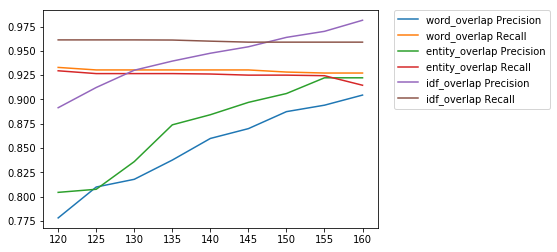

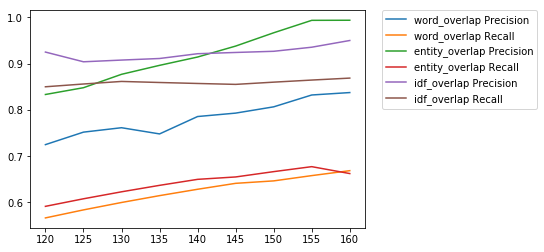

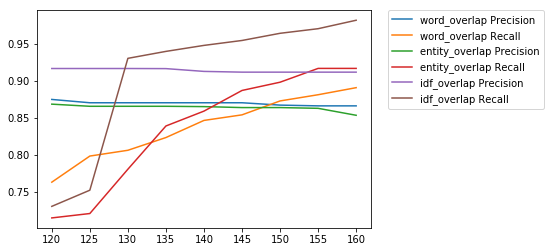

In [175]:
c = [120, 125, 130, 135, 140, 145, 150, 155, 160]
plt.plot(c,micro_pre1, label = "word_overlap Precision")
plt.plot(c,micro_re1, label = "word_overlap Recall")
plt.plot(c,micro_pre2, label = "entity_overlap Precision")
plt.plot(c,micro_re2, label = "entity_overlap Recall")
plt.plot(c,micro_pre3, label = "idf_overlap Precision")
plt.plot(c,micro_re3, label = "idf_overlap Recall")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

c = [120, 125, 130, 135, 140, 145, 150, 155, 160]
plt.plot(c,macro_pre1, label = "word_overlap Precision")
plt.plot(c,macro_re1, label = "word_overlap Recall")
plt.plot(c,macro_pre2, label = "entity_overlap Precision")
plt.plot(c,macro_re2, label = "entity_overlap Recall")
plt.plot(c,macro_pre3, label = "idf_overlap Precision")
plt.plot(c,macro_re3, label = "idf_overlap Recall")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

c = [120, 125, 130, 135, 140, 145, 150, 155, 160]
plt.plot(c,pairwise_pre1, label = "word_overlap Precision")
plt.plot(c,pairwise_re1, label = "word_overlap Recall")
plt.plot(c,pairwise_pre2, label = "entity_overlap Precision")
plt.plot(c,pairwise_re2, label = "entity_overlap Recall")
plt.plot(c,pairwise_pre3, label = "idf_overlap Precision")
plt.plot(c,pairwise_re3, label = "idf_overlap Recall")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [176]:
idx = 120
for i in range(len(macro_pre1)):
    print(idx)
    idx += 5
    print("precision-wordOverlap: " + str(macro_pre1[i]) + " " + str(micro_pre1[i]) + " " + str(pairwise_pre1[i]))
    print("recall-wordOverlap: " + str(macro_re1[i]) + " " + str(micro_re1[i]) + str(pairwise_re1[i]))
    print("precision-entityOverlap: " + str(macro_pre2[i]) + " " + str(micro_pre2[i]) + " " + str(pairwise_pre2[i]))
    print("recall-entityOverlap: " + str(macro_re2[i]) + " " + str(micro_re2[i]) + str(pairwise_re2[i]))
    print("precision-idf: " + str(macro_pre3[i]) + " " + str(micro_pre3[i]) + " " + str(pairwise_pre3[i]))
    print("recall-idf: " + str(macro_re3[i]) + " " + str(micro_re3[i]) + str(pairwise_re3[i]))

120
precision-wordOverlap: 0.725 0.7779705117085863 0.8745302110436542
recall-wordOverlap: 0.5666666666666667 0.93292859207863540.7627927146574154
precision-entityOverlap: 0.8333333333333334 0.8042786932639491 0.8681699913269731
recall-entityOverlap: 0.5916666666666667 0.92945938132408210.7145128649898814
precision-idf: 0.925 0.8914426134721017 0.9163052905464006
recall-idf: 0.85 0.96126047990748780.7301243133853715
125
precision-wordOverlap: 0.752 0.8097716102919919 0.8700491471523562
recall-wordOverlap: 0.584 0.93032668401272050.7980630239953744
precision-entityOverlap: 0.848 0.8074588031222897 0.8652789823648454
recall-entityOverlap: 0.608 0.92656837236195430.7204394333622435
precision-idf: 0.904 0.9122578779994218 0.9163052905464006
recall-idf: 0.856 0.96126047990748780.7519514310494363
130
precision-wordOverlap: 0.7615384615384615 0.8177218849378433 0.8700491471523562
recall-wordOverlap: 0.6 0.93032668401272050.8058687481931194
precision-entityOverlap: 0.8769230769230769 0.8359352

In [ ]:
## using word overlap

db = DBSCAN(eps=0.3, min_samples=10).fit(dbscan_word_mat)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y, labels))
print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(y, labels))

In [ ]:
## using entity overlap
db = DBSCAN(metric = "precomputed").fit(dbscan_entity_mat)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y, labels))
print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(y, labels))

In [226]:
## using 
db = DBSCAN(eps=2, min_samples=5, metric="precomputed").fit(df_matrix)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y, labels))
print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(y, labels))

Estimated number of clusters: 1
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000


In [207]:
list_in = []
keys = list(wordDict.keys())
for i in range(len(wordList)):
    temp = [0]*len(keys)
    entityValue = wordList[i]["entity"].lower().split()
    for item in entityValue:
        idx = keys.index(item)
        temp[idx] = 1
    list_in.append(temp)
    
db = DBSCAN(metric = "euclidean").fit(list_in)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y, labels))
print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(y, labels))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(list_in, labels))     

Estimated number of clusters: 178
Homogeneity: 0.987
Completeness: 0.954
V-measure: 0.970
Adjusted Rand Index: 0.966
Adjusted Mutual Information: 0.943
Silhouette Coefficient: 0.979


In [ ]:
list_in = []
keys = list(wordDict.keys())
for i in range(len(wordList)):
    temp = [0]*len(keys)
    entityValue = wordList[i]["entity"].lower().split()
    for item in entityValue:
        idx = keys.index(item)
        temp[idx] = 1
    list_in.append(temp)
    
db = DBSCAN(metric = "euclidean").fit(list_in)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y, labels))
print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(y, labels))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(list_in, labels))     